D-wave classes

In [3]:
#important:you need to enable the ocean virtual enviroment to run this code
import dimod #interface for D-wave
import neal  #simulator
from dwave.system import (DWaveSampler, EmbeddingComposite) #QPU sampler

Calling the D-wave solver (online version)

In [2]:
from dwave.cloud import Client
client = Client.from_config(token='')#insert your own token
client.get_solvers()

RequestTimeout: 

Scientific python libraries

In [4]:
import numpy as np              #scientific library
from numpy import linalg as LA  #linear algebra package
import matplotlib.pyplot as plt #plot library

Input

In [177]:
dim_matrix  =16      #dimension of the matrix  
num_of_bits =4       #number of bits used for diagonalization
num_of_reads=10      #number of reads from the simulator
zero_energy =True    #if only the state zero is used for computing the eigenvalue in the first part of the code 
beta        =100     #beta used for weighting the full response
epsilon_tol =0.001   #tollerance (the precision of the eigenvlue)

Precision vector and precision matrix 

In [178]:
p=np.empty([num_of_bits])
p[0]=-1
for b in range(2,num_of_bits+1):
    p[b-1]=2**(-b+1)
P=np.empty([dim_matrix,dim_matrix*num_of_bits])
P[:][:]=0
for i in range(dim_matrix):
    P[i][i*num_of_bits:(i+1)*num_of_bits]=p[:]

Function for writing arrays and vectors in the binary basis

In [179]:
def bin_matrix(A,prec):                       #prec=precision-->needed in the second part of the algorithm
    QA=prec**2*np.matmul(P.T,np.matmul(A,P))
    return QA
def bin_vector(v,prec):
    Qv=prec*np.matmul(v.T,P)
    return Qv

This comand select the anealer (simulator in this case)

In [180]:
#sampler = neal.SimulatedAnnealingSampler()#simulator (it sucks!)
sampler = EmbeddingComposite(DWaveSampler())#For what I have unerstood this command call the sampler
#and it maps your problem on the proper map of the annealer

#sampler.properties #properties of the sampler

Here we define the matrix to diagonalize and we compute for test the first eigenvector and first eigenvalue

In [181]:
#definition of the matrix (random)
I=np.eye(dim_matrix,dim_matrix)
np.random.seed(1234)
A=10*(np.random.rand(dim_matrix,dim_matrix)-0.5)
for i in range(dim_matrix):
    for j in range(dim_matrix):
        A[j][i]=A[i][j]
#eigenvalue and eigenvector computation
eval,evec=LA.eigh(A)
evec0=evec[::,0]
print("First eignevalue = ",eval[0])
print("First eigenvector= ",evec0)

First eignevalue =  -20.33834450366579
First eigenvector=  [-0.04231937  0.05425357 -0.26296477  0.01841736 -0.34848684 -0.25804524
 -0.18594637  0.28274039 -0.16145818 -0.34740964 -0.30821202  0.14002037
 -0.11329408  0.53446465 -0.23316614 -0.09492274]


Function for plotting

In [182]:
devec=[0]
deval=[0]
dprec=[0]
def plot(j,lam,v,prec):
    sign=np.sign(v[0])*np.sign(evec0[0])
    devec.append(-np.log10(np.sqrt(np.sum((v-sign*evec0)**2)))) #distance among the vectors
    deval.append(-np.log10(abs(eval[0]-lam)))
    dprec.append(-np.log10(prec))

First part of the algorithm: initial guess phase

In [183]:
lam=10**6
tmp_lam=np.trace(A)/dim_matrix
tot_time=0                     #total annealing time
print("Iteration= ",0,"Starting eigenvalue =", tmp_lam)
j=0
while tmp_lam < lam:
    j=j+1
    lam=tmp_lam
    #Rewriting the matrix in binary form
    QA=bin_matrix(A-lam*I,1) 
    #Transform our matrix in one managable by the D-wave                                                                                                              
    A_bqm = dimod.BinaryQuadraticModel.from_qubo(QA,offset=0.0)
    #Sampling simulator                                                                                                                                                        
    #sampleset = sampler.sample(A_bqm,num_reads=num_of_reads,beta_range=[0.1, 4.2],seed=3456)
    #sampling with the D-wave 
    sampleset = sampler.sample(A_bqm,num_reads=num_of_reads)
    #time
    timing = sampleset.info['timing']
    tot_time=tot_time+timing.get('qpu_access_time')
    #Sample database                                                                                                                                                  
    sample_len=len(sampleset.record.energy)
    #selecting the state with energy zero                                                                                                                                                   
    energy0=10**6
    for i in range(sample_len):
        energy=sampleset.record.energy[i]
        if(energy<energy0):
            energy0=energy
            indx=i
    if(zero_energy):                  #only state with zero energy is selected                                                                                     
        x=np.array(sampleset.record.sample[indx])
    else:                             #linear comination of the full response
        E0=sampleset.record.energy[indx]
        x=np.empty([dim_matrix*num_of_bits])
        for i in range(sample_len):
            x=x+sampleset.record.num_occurrences[i]*np.exp(-beta*(sampleset.record.energy[i]-E0))*sampleset.record.sample[i]
        x=x/num_of_reads
    if(np.matmul(x.T,x)<10**(-16)):   #if the best eigenvector is zero exit the loop
        print("exit loop")
        break
    tmp_v=np.matmul(P,x)                           #new eigenvector
    tmp_v_norm=np.sqrt(np.matmul(tmp_v.T,tmp_v))
    tmp_v=tmp_v/tmp_v_norm
    tmp_lam=np.matmul(tmp_v.T,np.matmul(A,tmp_v))  #new eigenvalue
    if(tmp_lam < lam):
        v=tmp_v
    print("Iteration= ",j," old value= ",lam," new value= ",tmp_lam)
print("End of the initial guess part")
print("Eigenvalue = ",lam)
print("Eigenvector= ",v)
print("Total annealing time= ",tot_time/1000000, "s")
#eigenvector error
sign=np.sign(v[0])*np.sign(evec0[0])
print("Eigenvector error= ",np.sqrt(np.sum((v-sign*evec0)**2)))

Iteration=  0 Starting eigenvalue = 0.011389214509541556
Iteration=  1  old value=  0.011389214509541556  new value=  -15.277695942962575
Iteration=  2  old value=  -15.277695942962575  new value=  -16.193712216875525
Iteration=  3  old value=  -16.193712216875525  new value=  -16.453285864281177
Iteration=  4  old value=  -16.453285864281177  new value=  -15.01827700902966
End of the initial guess part
Eigenvalue =  -16.453285864281177
Eigenvector=  [-0.16876319  0.39378077 -0.28127198 -0.11250879 -0.33752637 -0.33752637
 -0.11250879  0.33752637 -0.11250879 -0.39378077 -0.16876319  0.
 -0.11250879  0.28127198 -0.28127198  0.0562544 ]
Total annealing time=  0.068394 s
Eigenvector error=  0.5444716541457516


Iterative desendent phase

In [184]:
j=0
precision=0.1                     #precision
tot_time=0
while precision > epsilon_tol:                                                                                                                                                          
    j=j+1
    #Preparing the descendent direction
    H=A-lam*I
    vH=2.0*np.matmul(v.T,H)    
    QH=bin_matrix(H,precision)
    QvH=bin_vector(vH,precision)
    for i in range(dim_matrix*num_of_bits):
        QH[i][i]=QH[i][i]+QvH[i]
    #Transform our matrix in one managable by the D-wave                                                                                                              
    A_bqm = dimod.BinaryQuadraticModel.from_qubo(QH,offset=0.0)
    #Sampling                                 
    #sampleset = sampler.sample(A_bqm,num_reads=num_of_reads,beta_range=[0.1, 4.2],seed=3456)
    sampleset = sampler.sample(A_bqm,num_reads=num_of_reads)
    #time
    timing = sampleset.info['timing']
    tot_time=tot_time+timing.get('qpu_access_time')
    #Select the zero energy state                                                                                                                                                   
    energy0=10**6
    sample_len=len(sampleset.record.energy)
    #selecting the state with energy zero                                                                                                                                                   
    energy0=10**6
    for i in range(sample_len):
        energy=sampleset.record.energy[i]
        if(energy<energy0):
            energy0=energy
            indx=i
    #only state with zero energy is selected                                                                                     
    x=np.array(sampleset.record.sample[indx])
    delta=precision*np.matmul(P,x)       #delta vector
    delta=delta-np.matmul(delta.T,v)*v   #selcting the orthogonal part
    #Line search step
    Hd=np.matmul(H,delta)                                                                                                                          
    if(np.matmul(delta.T,delta)<10**(-16)):                                                                                                                              
        precision=precision*0.1
        plot(j,lam,v,precision)
        print("Iteration= ",j,"new precision = ",precision)
        continue
    tmin=-np.matmul(v.T,Hd)/np.matmul(delta,Hd)
    tmin=max(tmin,1)                                                                                                                                     
    delta=delta*tmin
    #new eigenvector
    tmp_v=v+delta
    tmp_norm=np.sqrt(np.matmul(tmp_v.T,tmp_v))
    tmp_v=tmp_v/tmp_norm
    #new eigenvalue
    tmp_lam=np.matmul(tmp_v.T,np.matmul(A,tmp_v))
    if(tmp_lam<lam):
        v=tmp_v
        print("Iteration= ",j," old value= ",lam," new value= ",tmp_lam)
        lam=tmp_lam
        plot(j,lam,v,precision)
    else:
        precision=precision*0.1
        print("Iteration= ",j,"new precision = ",precision)
        plot(j,lam,v,precision)
print("Final values")
print("Eigenvalue = ",lam)
print("Eigenvector= ",v)
print("Total annealing time= ",tot_time/1000000," s")

Iteration=  1  old value=  -16.453285864281177  new value=  -19.116770507386775
Iteration=  2  old value=  -19.116770507386775  new value=  -19.8183235758136
Iteration=  3  old value=  -19.8183235758136  new value=  -20.090405810871907
Iteration=  4  old value=  -20.090405810871907  new value=  -20.16037411887806
Iteration=  5 new precision =  0.010000000000000002
Iteration=  6  old value=  -20.16037411887806  new value=  -20.30524548228988
Iteration=  7  old value=  -20.30524548228988  new value=  -20.33206361051487
Iteration=  8  old value=  -20.33206361051487  new value=  -20.336397156627022
Iteration=  9  old value=  -20.336397156627022  new value=  -20.336905674142432
Iteration=  10  old value=  -20.336905674142432  new value=  -20.33705573394758
Iteration=  11 new precision =  0.0010000000000000002
Iteration=  12  old value=  -20.33705573394758  new value=  -20.337849557629355
Iteration=  13  old value=  -20.337849557629355  new value=  -20.338141100803057
Iteration=  14  old val

Plotting

<function matplotlib.pyplot.show(close=None, block=None)>

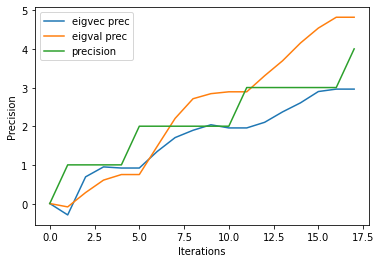

In [185]:
plt.plot(devec,label='eigvec prec')
plt.plot(deval,label='eigval prec')
plt.plot(dprec,label='precision')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Precision")
plt.show